In [1]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.discriminant_analysis import *
from sklearn.metrics import *

def weekday(x):
    if x == 'Monday': return 0
    elif x == 'Tuesday' : return 1
    elif x == 'Wednesday' : return 2
    elif x == 'Thursday' : return 3    
    elif x == 'Friday' : return 4
    elif x == 'Saturday' : return 5        
    elif x == 'Sunday' : return 6        

df = pd.read_csv("train.csv")
df['N_weekday'] = df['Weekday'].apply(weekday)

In [2]:
#  일단 nan 값 삭제
df = df.dropna(how='any')
df.reset_index(drop=True, inplace=True)

In [3]:
lb = LabelBinarizer() # 객체 생성
C_DD = lb.fit_transform(df['DepartmentDescription'].values.tolist()) # description을 카테고리화

#### ! - `DepartmentDescription`이 refund와 purchase를 구분하지 않음

In [4]:
df = pd.concat([df, pd.DataFrame(C_DD)], axis=1)
df.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,N_weekday,0,1,...,58,59,60,61,62,63,64,65,66,67
642920,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
642921,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
642922,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
642923,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
642924,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# df['total'] = df['ScanCount'].apply(abs) # Purchase + refund라 다중공선성 상승
df['refund'] = df['ScanCount'].apply(lambda x: -x if x < 0 else 0)
df['purchase'] = df['ScanCount'].apply(lambda x: x if x > 0 else 0)

In [6]:
df1 = df[['VisitNumber', 'TripType', 'N_weekday']].groupby('VisitNumber').mean()
df2 = df[['VisitNumber','refund','purchase']].groupby('VisitNumber').sum()
df3= pd.concat([df.iloc[:, 1], df.iloc[:,8:-3]], axis=1).groupby('VisitNumber').sum()

In [7]:
df1 = pd.concat([df1, df2], axis=1)
df = pd.concat([df1, df3], axis=1)
df['N_weekday'] = df['N_weekday'].apply(lambda x: str(x))  # 카테고리화

#scaling refund, purchase 
refund_scaler = StandardScaler()
df['refund'] = refund_scaler.fit_transform(df['refund'].values.reshape(-1, 1))

purchase_scaler = StandardScaler()
df['purchase'] = purchase_scaler.fit_transform(df['purchase'].values.reshape(-1, 1))

df.tail()

/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,TripType,N_weekday,refund,purchase,0,1,2,3,4,5,...,57,58,59,60,61,62,63,64,65,66
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191343,25,6,-0.252001,0.121662,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,22,6,-0.252001,-0.267713,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
191345,39,6,-0.252001,0.900413,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
191346,39,6,-0.252001,0.900413,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
191347,8,6,-0.252001,-0.559744,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = df.iloc[:, 1:]
y = df['TripType']

In [9]:
target_names = df['TripType'].unique()

In [10]:
target_names.sort()
target_names

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

In [11]:
qda = QuadraticDiscriminantAnalysis().fit(X, y)
lda = LinearDiscriminantAnalysis(n_components=3, solver="svd").fit(X, y)

y_pred = qda.predict(X)
y_pred2 = lda.predict(X)

print("QDA confusion_matrix \n\n",confusion_matrix(y, y_pred),"\n\n")
print("LDA confusion_matrix \n\n",confusion_matrix(y, y_pred2),"\n\n")

target_names = df['TripType'].unique()
target_names.sort()
target_names = list(map(lambda x: '{}'.format(x) , target_names))
print("QDA",classification_report(y, y_pred, target_names=target_names))
print("LDA",classification_report(y, y_pred2, target_names=target_names))


/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA confusion_matrix 

 [[  76  313    0 ...    0    0    0]
 [   0  182    0 ...    0    0    0]
 [   0 1626  243 ...    0    1    0]
 ...
 [   0  198    0 ...    1    2    0]
 [   0   40    0 ...   54  135    0]
 [   1 2420   15 ...    3    1   37]] 


LDA confusion_matrix 

 [[3458    0    1 ...    0    0    4]
 [   2    0  125 ...    0    0    0]
 [  25    0 1505 ...    0    1    8]
 ...
 [  59    0   35 ...   10    1    2]
 [   6    0   30 ...    3   43    0]
 [ 781    0   89 ...    1    0 4670]] 


QDA              precision    recall  f1-score   support

          3       0.99      0.02      0.04      3643
          4       0.00      0.53      0.01       346
          5       0.91      0.07      0.13      3366
          6       0.59      0.45      0.51      1277
          7       0.20      0.00      0.00      5752
          8       0.00      0.00      0.00     12161
          9       0.00      0.00      0.00      9464
         12       0.01      0.61      0.03       269
        

/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1. LDA가 QDA보다 더 잘맞음
1. "Variables are collinear" -> description이 많아서 뜨는 듯.

In [12]:
from sklearn.multiclass import OneVsRestClassifier
model1 = OneVsRestClassifier(QuadraticDiscriminantAnalysis()).fit(X, y)
model2 = OneVsRestClassifier(LinearDiscriminantAnalysis(n_components=3, 
                                 solver="svd", store_covariance=True)).fit(X, y)

/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/mk/a

In [13]:
y1 = lb.fit_transform(y) 

auc: 0.9731240191409849
auc: 0.9331307945589972
auc: 0.8866227033434377


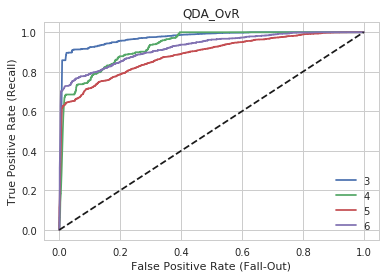

In [14]:
fpr1, tpr1, thresholds1 =roc_curve(y1[:,0], model1.decision_function(X)[:,0])
fpr2, tpr2, thresholds2 =roc_curve(y1[:,1], model1.decision_function(X)[:,1])
fpr3, tpr3, thresholds3 =roc_curve(y1[:,2], model1.decision_function(X)[:,2])
fpr4, tpr4, thresholds4 =roc_curve(y1[:,3], model1.decision_function(X)[:,3])

plt.plot(fpr1, tpr1, label="3")
plt.plot(fpr2, tpr2, label="4")
plt.plot(fpr3, tpr3, label="5")
plt.plot(fpr4, tpr4, label="6")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('QDA_OvR')
print ("auc:",auc(fpr1, tpr1))
print ("auc:",auc(fpr2, tpr2))
print ("auc:",auc(fpr3, tpr3))

plt.show()

auc: 0.9918062260977487
auc: 0.9588334577931142
auc: 0.9604998974094761


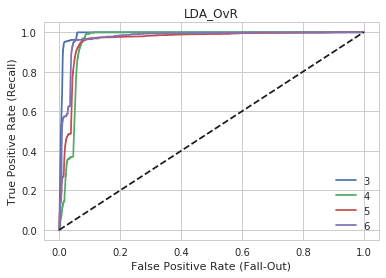

In [15]:
fpr1, tpr1, thresholds1 =roc_curve(y1[:,0], model2.decision_function(X)[:,0])
fpr2, tpr2, thresholds2 =roc_curve(y1[:,1], model2.decision_function(X)[:,1])
fpr3, tpr3, thresholds3 =roc_curve(y1[:,2], model2.decision_function(X)[:,2])
fpr4, tpr4, thresholds4 =roc_curve(y1[:,3], model2.decision_function(X)[:,3])

plt.plot(fpr1, tpr1, label="3")
plt.plot(fpr2, tpr2, label="4")
plt.plot(fpr3, tpr3, label="5")
plt.plot(fpr4, tpr4, label="6")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('LDA_OvR')
print ("auc:",auc(fpr1, tpr1))
print ("auc:",auc(fpr2, tpr2))
print ("auc:",auc(fpr3, tpr3))

plt.show()